In [1]:
#import

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping

#parameter

ng = 1.517 #diffractive index of glass
lam = 852e-9 #wave length[m]
R = 40e-3 #curvature radius[m]
L = 8.4e-3 #length of cavity[m]
f = np.array([100,150,200,250,300,400,500,750,1000])*1e-3 #focus length[m]

#stability condition of FilterCavity

def stabCal(L,R,lam,n=1):
    ML = np.array([[1,L/2],[0,1]])
    MR = np.array([[1,0],[-2/R,1]]) #曲面鏡での反射

    M = np.matmul(MR,ML)
    M = np.matmul(ML,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    R_cav = 2*B/(D-A)
    Omega_cav = np.sqrt(2*B*lam/(np.pi*n*np.sqrt(4-(A+D)**2)))
    return R_cav, Omega_cav

R_cav ,Omega_cav = stabCal(L,R,lam)
print("R_cav=",R_cav)
print("Omega_cav=",Omega_cav,"[m]")

共振安定条件は上記のようにlens cavityのときと同様に計算できる。\
lens cavityのときとの相違点は入射光の光線追跡をどこまでするのかである。\
Fabry Pelot cavityの場合、d1並進>lens1>d2並進>lens2>d3並進>mirror入射>mirror内並進>共振器内入射>L/2並進となる。\
共振器に入射する時はn=1.517のBK7というガラスを透過する。

# Collimation check

コリメートが正確にできているかは、レイリー長を計算することで見積もることができる.\
光学系におけるパスの全長よりもレイリー長が十分長ければ、その光学系の中では平行光であるとみなしてよい.

beam waist position -0.19705940510920833 [m]
beam waist radius 7.932731833503981e-05 [m]
Rayleigh length: 0.02320362426210178 [m]


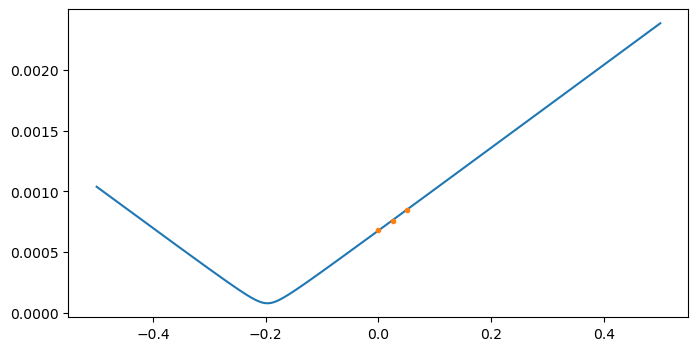

In [5]:
zs = np.array([0, 25, 50])*1e-3 #[m]
ws = np.array([680, 760, 850])*1e-6 #[m]

n = 1

#任意の位置:zにおけるビーム径を
def waist(z, z0, w0):
    z_R = np.pi*w0**2*n/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-500e-3, 500e-3, 1001)

popt, pcov = curve_fit(waist, zs, ws)
print("beam waist position",popt[0],"[m]")
print("beam waist radius",popt[1],"[m]")
print("Rayleigh length:",np.pi*popt[1]**2*n/lam,"[m]")

plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.show()

この結果が測定地点前後がレイリー長の範囲内であれば、Perfect collimationで計算すればよい。\
逆にレイリー長の範囲外であれば、Imperfect collimationで計算することになる。\
ここでは最も一般的なImperfect collimation conditionでのmodematchの計算をしていく。

# Imperfect collimation condition (for two lens)

waist position: -2.0905532564150757 [m]
beam waist: 0.0006142841446121676 [m]


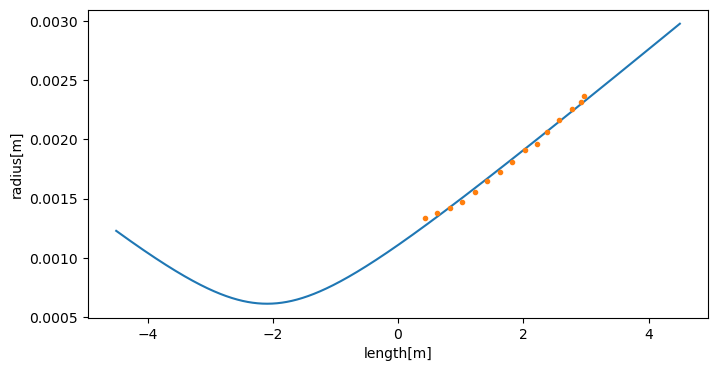

In [5]:
zs = np.array([17,25,33,41,49,57,65,73,81,89,95,103,111,117,119])*25*1e-3 #[m]
ws = np.array([1339,1379,1424,1475,1555,1652,1728,1810,1909,1958,2066,2165,2253,2313,2363])*1e-6 #[m]

lam = 852.3e-9

def waist(z, z0, w0):
    z_R = np.pi*1*w0**2/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-4500e-3, 4500e-3, 9001)

popt, pcov = curve_fit(waist, zs, ws)
waist_position, Omega0 = popt
print("waist position:",waist_position,"[m]")
print("beam waist:",Omega0,"[m]")

plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.xlabel("length[m]")
plt.ylabel("radius[m]")
plt.show()

In [ ]:
# RayTransferMatrix
def matrixCal(d,f1,f2,n):
    d1=d[0]
    d2=d[1]
    d3=d[2]
    Mf1 = np.array([[1,0],[-1/f1,1]])
    Mf2 = np.array([[1,0],[-1/f2,1]])
    Md1 = np.array([[1,d1],[0,1]])
    Md2 = np.array([[1,d2],[0,1]])
    Md3 = np.array([[1,d3],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Mf1,Md1)
    M=np.matmul(Md2,M)
    M=np.matmul(Mf2,M)
    M=np.matmul(Md3,M)
    M=np.matmul(Mn,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*1*Omega0**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    q_out_inverse = 1/q_out
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi*1)
    #Omega_dash = np.sqrt(- lam/(np.pi*1*q_out_inverse.imag))
    R_dash = 1/q_out_inverse.real
    return Omega_dash, R_dash

def objective(d,f1,f2,n):
    diameter_error = (matrixCal(d,f1,f2,n)[0]- Omega_cav)**2
    return diameter_error

def curvature_constraint(d,f1,f2,n):
    return 1/matrixCal(d,f1,f2,n)[1]

# d1,d2,d3の範囲, 初期値
bounds = [(d1_range_start-waist_position, d1_range_end-waist_position), (tube_length, tube_length+adjuster), (d3_range_start, d3_range_end)]

initial_guesses = [
    [bounds[0][0], bounds[1][0], bounds[2][0]],
    [(bounds[0][0] + bounds[0][1]) / 2, (bounds[1][0] + bounds[1][1]) / 2, (bounds[2][0] + bounds[2][1]) / 2],
    [bounds[0][1], bounds[1][1], bounds[2][1]]
]

final_list = []
for i in f:  # f1
    for j in f:  # f2
        constraints = {
            'type': 'eq',  # 等式制約
            'fun': curvature_constraint,
            'args': (i, j, ng)
        }
        
        # グローバル最適化を実行
        for initial_guess in initial_guesses:
            minimizer_kwargs = {
                'method': 'SLSQP',
                'args': (i, j, ng),
                'bounds': bounds,
                'constraints': constraints
            }
            
            result = basinhopping(
                objective,
                initial_guess,
                minimizer_kwargs=minimizer_kwargs,
                niter=10  # 反復回数は適宜調整
            )
            
            if result.lowest_optimization_result.success:
                optimized_d1, optimized_d2, optimized_d3 = result.x
                final_radius, final_curvature = matrixCal([optimized_d1, optimized_d2, optimized_d3], i, j, ng)
                final_list.append((final_radius, final_curvature, optimized_d1, optimized_d2, optimized_d3, i, j))
                print("a")
            
if final_list:
    closest_radius = min(final_list, key=lambda x: abs(x[0] - Omega_cav))
    print("Omega cavity:", Omega_cav,"[m]")
    print(f"final radius: {closest_radius[0]}[m]")
    print(f"final cuevature radius:{closest_radius[1]}[m]")
    print(f"出射ポートからlens1までの距離: {(closest_radius[2]+waist_position) * 1e3} [mm], d2: {closest_radius[3] * 1e3} [mm], d3: {closest_radius[4] * 1e3} [mm]")
    print(f"focus length 1: {closest_radius[5] * 1e3} [mm], focus length 2: {closest_radius[6] * 1e3} [mm]")